<a href="https://colab.research.google.com/github/andrebelem/pythonverse/blob/main/Spillhaus_projection_experiment_%5BPyGMT%2BCOLAB%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Experimentos for Spilhaus projection (it need improvements!).


Combining pygmt with some python+math magic.

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:16
🔁 Restarting kernel...


In [2]:
%%capture
!mamba install pygmt # hiding comments to prevent a lot of messages

In [3]:
# Load the PyGMT package. This only needs to be run once
import pygmt

In [32]:
grid = pygmt.datasets.load_earth_relief(resolution='01d', region=None)

In [33]:
# note you have lat and lon and topo values in a grid
grid

<xarray.DataArray 'z' (lat: 181, lon: 361)> Size: 523kB
array([[ 2865. ,  2865. ,  2865. , ...,  2865. ,  2865. ,  2865. ],
       [ 3088. ,  3087.5,  3087. , ...,  3088.5,  3088. ,  3088. ],
       [ 3100.5,  3100.5,  3101. , ...,  3101.5,  3101. ,  3100.5],
       ...,
       [-3745.5, -3731. , -3723. , ..., -3734. , -3741.5, -3745.5],
       [-2939.5, -2945. , -2950.5, ..., -2895. , -2921. , -2939.5],
       [-3861. , -3861. , -3861. , ..., -3861. , -3861. , -3861. ]])
Coordinates:
  * lat      (lat) float64 1kB -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 3kB -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
Attributes:
    Conventions:       CF-1.7
    title:             SRTM15 Earth Relief v2.6 at 01 arc degree
    history:           
    description:       IGPP Earth relief
    long_name:         elevation (m)
    units:             meters
    vertical_datum:    EGM96
    horizontal_datum:  WGS84

Define some maths and transforms for Spillhaus in a square....taken from https://github.com/OSGeo/PROJ/issues/1851#issuecomment-889966275 and converted  to python

In [42]:
import math
import numpy as np
import xarray as xr

alpha = math.radians(30)
sin_alpha = math.sin(alpha)
cos_alpha = math.cos(alpha)
beta = math.radians(-28.8013495219182)

class ProjCoordinate:
    def __init__(self, x=0, y=0):
        self.x = x
        self.y = y

def normalize_longitude(lon):
    while lon < -math.pi:
        lon += 2 * math.pi
    while lon > math.pi:
        lon -= 2 * math.pi
    return lon

def change_pole(lon, lat, out):
    cos_lat = math.cos(-lat)
    sin_lat = math.sin(-lat)
    cos_lon = math.cos(-lon)
    sin_lon = math.sin(-lon)
    sin_lat_p = sin_alpha * sin_lat - cos_alpha * cos_lat * cos_lon
    lat_p = math.asin(sin_lat_p)
    lon_p = math.atan2(cos_lat * sin_lon, sin_alpha * cos_lat * cos_lon + cos_alpha * sin_lat) + beta
    out.x = -normalize_longitude(lon_p)
    out.y = -lat_p
    return out

def ell_int_5(x):
    # Placeholder for the elliptic integral, which should be implemented as needed.
    return x

def project(lon, lat, xy):
    e = 0.081819190842622  # eccentricity of the ellipsoid

    # Conformal latitude
    conformal_lat = 2 * math.atan(math.tan(math.pi / 4 + lat / 2) * math.pow((1 - e * math.sin(lat)) / (1 + e * math.sin(lat)), e / 2)) - math.pi / 2
    rot_lon_lat = change_pole(lon, conformal_lat, ProjCoordinate())
    lon = rot_lon_lat.x
    lat = rot_lon_lat.y

    spp = math.tan(0.5 * lat)
    sa = math.cos(math.asin(spp)) * math.sin(0.5 * lon)
    b = math.acos(spp)
    a = math.acos(math.cos(math.asin(spp)) * math.sin(0.5 * lon))

    xy.x = ell_int_5(((spp + sa) < 0 and -1 or 1) * math.asin(math.sqrt((1.0 + min(0.0, math.cos(a + b))))))
    xy.y = ell_int_5(((spp - sa) < 0 and -1 or 1) * math.asin(math.sqrt(abs(1.0 - max(0.0, math.cos(a - b))))))

    return xy

# Function to reproject coordinates in an xarray.DataArray
def reproject_bathymetry(grid):
    lons = np.radians(grid['lon'].values)
    lats = np.radians(grid['lat'].values)

    new_x = np.zeros((lats.size, lons.size))
    new_y = np.zeros((lats.size, lons.size))

    for i, lat in enumerate(lats):
        for j, lon in enumerate(lons):
            coord = ProjCoordinate()
            project(lon, lat, coord)
            new_x[i, j] = coord.x
            new_y[i, j] = coord.y

    new_grid = xr.Dataset({
        'topo': (['lat', 'lon'], grid.values)
    }, coords={
        'x': (['lat', 'lon'], new_x),
        'y': (['lat', 'lon'], new_y)
    })

    return new_grid


do the magic ...

In [43]:
reprojected_grid = reproject_bathymetry(grid)

Just a simple plot. We still need an implementation of `surface` based on `reprojected_grid.to_dataframe()`.

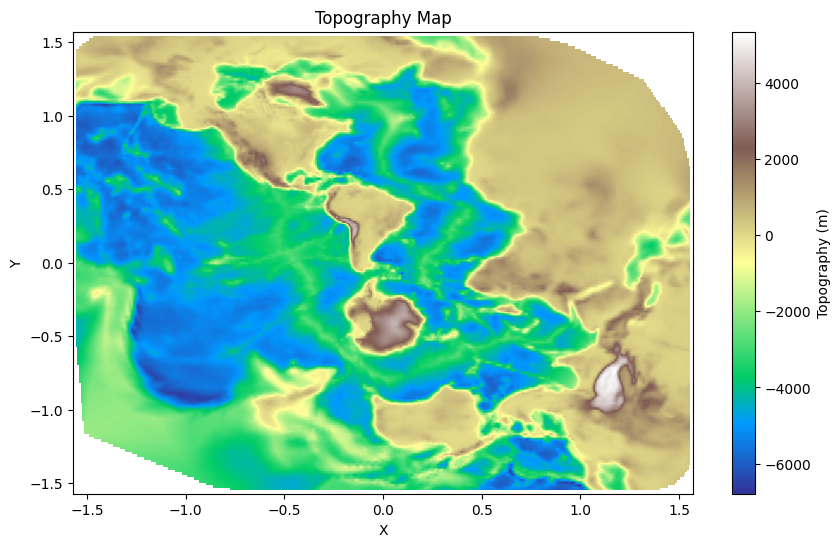

In [44]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Extracting the coordinates x, y, and the topography data
x = reprojected_grid['x'].values
y = reprojected_grid['y'].values
topo = reprojected_grid['topo'].values

# Create a regular grid in the new coordinates x and y
xi = np.linspace(x.min(), x.max(), x.shape[1])
yi = np.linspace(y.min(), y.max(), y.shape[0])
xi, yi = np.meshgrid(xi, yi)

# Interpolate the topography data to the new grid
topo_interp = griddata((x.ravel(), y.ravel()), topo.ravel(), (xi, yi), method='linear')

# Creating the plot
plt.figure(figsize=(10, 6))
plt.imshow(topo_interp, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='terrain', aspect='auto')
plt.colorbar(label='Topography (m)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Topography Map')
plt.show()
